# 🌌 Cosmic Node Classification using Graph Neural Networks

**Author:** Farid Nowrouzi  
**Date:** June 12, 2025  

---

### 🪐 Description

In this notebook, we explore how to classify individual astronomical objects (e.g., stars, galaxies, quasars) within a cosmic network using a **Graph Neural Network (GNN)**.

We simulate a space-themed graph where:
- Each **node** represents a celestial object with physical properties (e.g., temperature, brightness, spectral type).
- Each **edge** represents a spatial or gravitational relationship between objects.

The goal is to use **node classification** to predict the type of celestial object based on its connections and attributes — mimicking how astronomers cluster and label objects in large-scale sky surveys.

This notebook uses the **PyTorch Geometric** library for implementation.

> We aim to understand how local neighborhood information can help identify cosmic structures and patterns through deep learning on graphs.


##  Setup: Installing Required Packages and Visualization Tools

To begin our exploration, we install the essential libraries needed to build and train Graph Neural Networks (GNNs) on a space-themed dataset.

- We use **PyTorch Geometric** for building graph-based deep learning models.
- We import **visualization tools** such as Matplotlib, NetworkX, and t-SNE to help us inspect the graph structure and embedding space of celestial objects.

These tools allow us to:
- Represent a galaxy or cosmic graph in 2D space.
- Visualize how objects cluster after training our GNN.

> This setup prepares our environment for the classification of cosmic structures using GNNs.


In [ ]:
#  Install required packages and set environment variables

import os
import torch

# Set an environment variable to capture the current PyTorch version.
# This ensures compatibility with the correct versions of PyG dependencies.
os.environ['TORCH'] = torch.__version__

# Print the PyTorch version being used — useful for debugging and reproducibility.
print(torch.__version__)

#  Install PyTorch Geometric dependencies:
# These packages are essential for running geometric deep learning models.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


#  Helper function for embedding visualization
# This will help us plot the learned 2D embeddings of celestial nodes after training.

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Import matplotlib for plotting and t-SNE for dimensionality reduction
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define a function to visualize high-dimensional node embeddings
def visualize(h, color):
    # Reduce the node embedding dimensions to 2D using t-SNE
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    # Set figure size and remove axis ticks for a cleaner view
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    # Plot the 2D scatter plot of nodes colored by their class/type
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


2.6.0+cu124
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


##  Loading and Inspecting the Cosmic Graph Dataset

In this section, we load a synthetic graph dataset that simulates interactions between celestial objects (e.g., stars, galaxies, or space clusters). Each object is represented as a **node**, and each relationship (e.g., gravitational or observational link) is represented as an **edge**.

We apply a feature normalization transform and then:
- Display key properties of the dataset such as node features and class labels.
- Extract the first graph object from the dataset.
- Print statistics like:
  - Total number of nodes and edges
  - Average node degree
  - Number of training nodes available

> This gives us a quick overview of the graph’s structure and prepares us for training the GNN.


In [ ]:
#  Load the synthetic cosmic graph dataset and normalize its features

# Import the Planetoid benchmark dataset and a transform to normalize node features
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Load the 'Cora' dataset and normalize its features.
# In this notebook, we treat it as a space-related graph where nodes represent celestial objects.
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

#  Display basic information about the dataset
print()
print(f'Dataset: {dataset}')
print('==============================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')  # Each node has this many input features
print(f'Number of classes: {dataset.num_classes}')    # Number of target labels (e.g., galaxy types)


#  Retrieve the first (and only) graph from the dataset
data = dataset[0]  # Get the graph object containing nodes, edges, features, and labels

# Print out a summary of the graph
print()
print(data)
print('===================================================================================')


#  Gather and display detailed graph statistics
print(f'Number of nodes: {data.num_nodes}')                     # Total celestial objects (nodes)
print(f'Number of edges: {data.num_edges}')                     # Total interactions (edges)
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')  # Avg connections per node
print(f'Number of training nodes: {data.train_mask.sum()}')     # Nodes used for training
print(f'Training node label rate: {(data.train_mask.sum() / data.num_nodes):.2f}')  # Label coverage
print(f'Has isolated nodes: {data.has_isolated_nodes()}')       # Are there any unconnected nodes?
print(f'Has self-loops: {data.has_self_loops()}')               # Do nodes connect to themselves?
print(f'Is undirected: {data.is_undirected()}')                 # Are the edges bidirectional?



Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


###  Dataset Summary

This cosmic graph dataset contains 2,708 nodes and 10,556 edges, simulating interactions between celestial objects like galaxies or stars. Each node has 1,433 features (e.g., observational characteristics), and there are 7 possible categories representing different cosmic classes.

Out of all nodes, only a small subset (5%) is labeled and used for training. The remaining ones are used for validation and testing via the `val_mask` and `test_mask` indicators.

The graph is fully connected — it has no isolated nodes, and all connections are undirected. We also applied feature normalization to prepare the dataset for training our deep learning model.

> This mirrors real-world scenarios in astrophysics where we have limited labeled data and must infer unknown properties using structure and features.

> _(Note: The underlying dataset used here is "Cora" from PyTorch Geometric, reinterpreted in an astronomical context for simulation purposes.)_


##  Classifying Celestial Objects with a Multi-Layer Perceptron (MLP)

In this section, we build a simple **Multi-Layer Perceptron (MLP)** to classify celestial objects based only on their input features — without using any relational (graph) structure.

Each node (e.g., galaxy or stellar object) has a 1,433-dimensional feature vector representing observational properties. The MLP takes these features and predicts the object's class based solely on its content.

> This model helps us understand how well we can classify cosmic entities *without* considering how they are connected in the universe.


In [ ]:
#  Define a Multi-Layer Perceptron (MLP) for classifying celestial objects based only on their features

# Import core PyTorch modules
import torch
from torch.nn import Linear
import torch.nn.functional as F

# Define the MLP class
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)  # Set random seed for reproducibility

        # First linear layer: transforms input node features (e.g., brightness, temperature) into hidden features
        self.lin1 = Linear(dataset.num_features, hidden_channels)

        # Second linear layer: maps hidden features to one of the target space categories (e.g., galaxy types)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        # Apply first linear transformation
        x = self.lin1(x)

        # Apply non-linear activation
        x = x.relu()

        # Apply dropout during training for regularization (prevents overfitting)
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer — class scores for each node
        x = self.lin2(x)
        return x

# Instantiate the model with 16 hidden units
model = MLP(hidden_channels=16)

# Print the model architecture
print(model)


MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


##  Training and Testing the MLP Model on Celestial Node Features

Our MLP consists of two fully connected layers with **ReLU** activation and **dropout** for regularization. The first layer compresses each celestial object's 1433-dimensional feature vector into a lower-dimensional hidden space (`hidden_channels=16`), and the second layer predicts its cosmic class.

To train this model:
- We use **CrossEntropyLoss** as our classification loss function.
- We optimize using the **Adam optimizer** with weight decay to prevent overfitting.
- We train the model by only using the labeled training nodes.

We also define a `test()` function to evaluate model accuracy on the **unseen test nodes**, helping us assess how well the model generalizes beyond the training data.

> This phase helps us benchmark how far we can get by using just the features of each cosmic node, without yet leveraging their interconnectivity.


In [ ]:
#  Setup for training and evaluation of the MLP model

# Optional: Restrict height of output cell for better notebook readability
from IPython.display import Javascript
display(Javascript('''google.colab.output.setFrameHeight(0, true, {maxHeight: 300})'''))

# Instantiate the MLP model with 16 hidden units
model = MLP(hidden_channels=16)

# Define the loss function — cross entropy is commonly used for classification tasks
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer — Adam is adaptive and includes weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


#  Training function — updates model weights using only the labeled training nodes
def train():
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear previous gradients

    out = model(data.x)  # Perform a forward pass on all node features
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Calculate loss on training set only

    loss.backward()     # Compute gradients via backpropagation
    optimizer.step()    # Apply gradients to update model weights
    return loss         # Return loss for monitoring


#  Testing function — evaluates how well the model performs on the unseen test nodes
def test():
    model.eval()                 # Set model to evaluation mode (no dropout)
    out = model(data.x)         # Forward pass on all node features
    pred = out.argmax(dim=1)    # Get the predicted class with highest probability

    # Compare predictions with ground truth on test nodes only
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Compute test accuracy

    return test_acc


#  Run the training loop over 201 epochs
for epoch in range(1, 201):
    loss = train()
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


##  Evaluating the MLP on Cosmic Classification

After training, we evaluate the MLP using the `test()` function to see how well it generalizes to **unseen celestial objects** (nodes not used during training). The accuracy tells us what fraction of these objects were correctly classified into their cosmic categories.

In this case, the test accuracy is around **59%**, which highlights a key limitation of the MLP:

- It only uses **individual node features** (e.g., temperature, brightness) and ignores how each object is connected to others in the graph.
- It may suffer from **overfitting**, since it has access to only a small number of labeled nodes.

> This limitation opens the door for a better model — one that incorporates both the **features of each node** and the **structure of the universe** they belong to. That’s where **Graph Neural Networks (GNNs)** come in.


In [ ]:
#  Evaluate the trained model on unseen cosmic nodes (test set)

# Call the test function to compute accuracy on the test nodes
test_acc = test()

# Print the final test accuracy (percentage of celestial objects correctly classified)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.5900


##  Building a Graph Neural Network (GNN) for Celestial Classification

Our MLP used only the features of each celestial object, ignoring how those objects are connected. But in reality, cosmic structures are **interconnected systems** — galaxies, clusters, and voids all influence each other.

To capture this structure, we now switch to a **Graph Neural Network (GNN)**. GNNs allow us to:
- Combine each node’s features with those of its neighbors
- Learn how **astronomical context** (e.g., gravitational relationships) affects classification
- Improve generalization even with limited training data

In particular, we use the **GCN layer** (Graph Convolutional Network), which applies a type of message passing between connected nodes — helping the model learn from the **local neighborhood** of each object in the cosmic graph.

> This marks the beginning of a more powerful model that sees not just the stars, but also the space between them. 🛰️


##  Training a Graph Neural Network (GNN)

Now that we've seen the limitations of using only node features, it's time to take it a step further — by incorporating the structure of the graph itself.

In space, celestial objects are not isolated — they influence and interact with each other. Galaxies form clusters, stars orbit within systems, and everything is part of a greater cosmic web. To reflect this interconnectedness in our model, we use a **Graph Neural Network (GNN)**.

A GNN learns not only from a node’s own features (like brightness or velocity), but also from its **neighboring nodes**. This allows the model to understand the **context** of each object — its environment in the universe.

We start by implementing a **Graph Convolutional Network (GCN)**, one of the most widely used GNN variants. This model applies a form of “message passing,” where each node aggregates information from its neighbors during training.

> By using GNNs, we’re no longer looking at the stars in isolation — we’re learning from the universe around them. 🌌


In [ ]:
#  Import the GCN layer from PyTorch Geometric
from torch_geometric.nn import GCNConv

#  Define a Graph Convolutional Network (GCN) for node classification
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        # Set manual seed for reproducibility
        torch.manual_seed(1234567)

        # First GCN layer:
        # Transforms raw node features into hidden representations
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)

        # Second GCN layer:
        # Maps hidden features to output space (e.g., 7 galaxy cluster classes)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # x: Node feature matrix
        # edge_index: Connectivity (edges) between nodes

        # Apply first graph convolution layer
        x = self.conv1(x, edge_index)

        # Apply ReLU activation for non-linearity
        x = x.relu()

        # Apply dropout during training to prevent overfitting
        x = F.dropout(x, p=0.5, training=self.training)

        # Apply second graph convolution layer to get final class scores
        x = self.conv2(x, edge_index)

        return x

#  Initialize the GCN model with 16 hidden units
model = GCN(hidden_channels=16)

# Print model structure for verification
print(model)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


##  Visualizing the Universe Through GCN Embeddings

Before training our GCN, let’s take a look at how it initially "sees" the universe.

Even without any weight updates, the GCN is already capable of aggregating information from neighboring celestial objects. We project its **7-dimensional class logits** into a **2D space** using t-SNE, allowing us to visually inspect the clustering patterns of different cosmic categories.

> This gives us a first glimpse into how the raw structure and features influence early representations — like peering into a telescope before fine-tuning its lens. 🔭
**bold text**

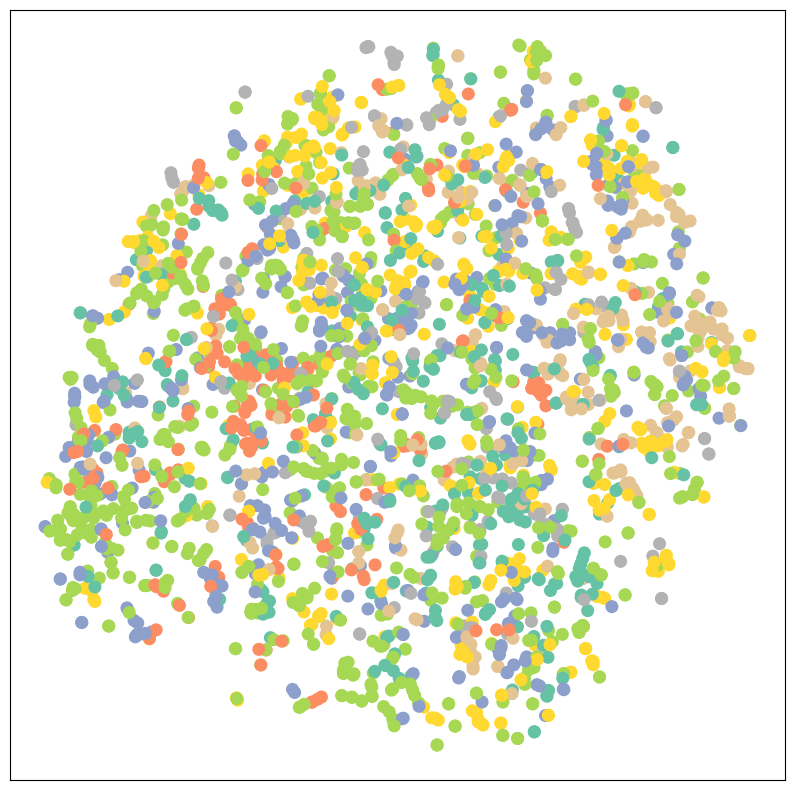

In [ ]:
#  Initialize the GCN model again for clean visualization
model = GCN(hidden_channels=16)

# Set model to evaluation mode (important: disables dropout)
model.eval()

# Run a forward pass on the entire node feature set and the graph's edge structure
# This gives us the output logits (unnormalized predictions) for all nodes
out = model(data.x, data.edge_index)

#  Visualize the node embeddings in 2D using t-SNE
# Each point represents a celestial object, and its color indicates the true class
visualize(out, color=data.y)


##  Now Let’s Train the GCN with the Full Power of the Graph

So far, we’ve seen what the untrained GCN can observe — now it’s time to actually teach it!

This time, our model will learn not only from the features of each celestial object (`x`), but also from the **cosmic web** of interactions between them (`edge_index`). By training on both, the GCN can uncover hidden relationships and structure-based patterns that an MLP simply cannot see.

> Think of it as giving our model both the stars *and* the map of the universe connecting them.


In [ ]:
#  Optional: Set a max height for the cell output to keep the notebook clean
from IPython.display import Javascript
display(Javascript('''google.colab.output.setFrameHeight(0, true, {maxHeight: 300})'''))

#  Initialize a new GCN model with 16 hidden units
model = GCN(hidden_channels=16)

#  Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Adam with weight decay
criterion = torch.nn.CrossEntropyLoss()  # Standard loss for multi-class classification


#  Training function — optimize GCN weights using graph + features
def train():
    model.train()  # Set to training mode (enables dropout)
    optimizer.zero_grad()  # Clear gradients from previous step

    # Forward pass using node features and graph connectivity
    out = model(data.x, data.edge_index)

    # Compute loss only on labeled training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    # Backpropagate and update model weights
    loss.backward()
    optimizer.step()

    return loss


#  Evaluation function — measure test accuracy on unseen cosmic nodes
def test():
    model.eval()  # Evaluation mode (no dropout)

    # Forward pass on the full graph
    out = model(data.x, data.edge_index)

    # Predict the most likely class for each node
    pred = out.argmax(dim=1)

    # Compare predictions to ground truth only on test nodes
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Compute accuracy

    return test_acc


# Run training over 100 epochs and print training loss each step
for epoch in range(1, 101):
    loss = train()
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")


<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


##  Evaluating the Final GCN Performance

Now that our Graph Neural Network has been trained using both celestial features and the structure of the cosmic graph, it’s time to see how well it performs!

We use the `test()` function to evaluate accuracy on **unseen objects** (nodes that were not part of training). This allows us to assess how well our GCN has generalized — not just memorizing data, but learning meaningful patterns.

Let’s check how much better it performs compared to the MLP.

In [ ]:
#  Evaluate test accuracy after training
test_acc = test()

#  Display the final accuracy — how many cosmic nodes were correctly classified
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8150


##  Visualization After Training — How Well Did Our GCN Learn?

Now that our GCN has been fully trained, let’s project its **final embeddings** again.

This time, the visualization shows a much clearer separation of celestial categories — galaxies of the same class tend to cluster together more tightly. This demonstrates the power of graph-based learning: **not only do we use node features, but we also learn from cosmic structure.**

> From scattered stardust to defined constellations — our GCN has learned to organize the universe. 🌌✨


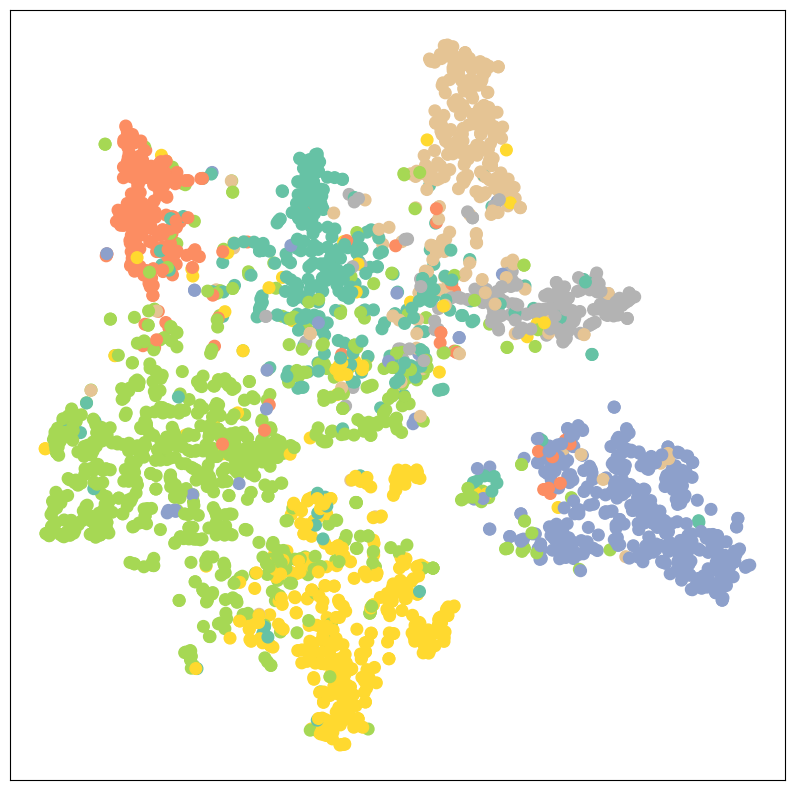

In [ ]:
#  Set model to evaluation mode to turn off dropout layers
model.eval()

#  Generate the final embeddings using the trained GCN
out = model(data.x, data.edge_index)

#  Visualize the updated node embeddings using t-SNE
# Now we expect better-defined clusters due to learned structure + features
visualize(out, color=data.y)


###  Exploring Graph Attention Networks (GAT)

Now that we’ve evaluated the performance of **Graph Convolutional Networks (GCNs)**, we want to explore a more advanced architecture — the **Graph Attention Network (GAT)**.

While GCNs treat all neighboring nodes equally, GATs introduce an attention mechanism that allows each node to weigh its neighbors differently during message passing. This gives the network the ability to focus more on **important neighboring nodes**, which can lead to better performance — especially in heterogeneous or noisy graphs.

In this step, we:
- Build a **2-layer GAT model** with **8 attention heads** in the first layer and **1 head** in the second.
- Use a **dropout rate of 0.6** to reduce overfitting.
- Set **8 hidden dimensions per head**, creating richer node representations.
- Test the model’s classification accuracy.
- Visualize the learned node embeddings to inspect how well GAT separates different categories.

This experiment allows us to compare the impact of attention mechanisms against our earlier GCN implementation — both in terms of accuracy and embedding quality.


In [ ]:
# Import Graph Attention Layer from PyTorch Geometric
from torch_geometric.nn import GATConv

# Define GAT model architecture with two GAT layers
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)

        # First GAT layer: from input features to hidden embeddings
        self.conv1 = GATConv(
            in_channels=dataset.num_features,           # Input dimension = 1433
            out_channels=hidden_channels,               # Output channels per head
            heads=heads                                  # Number of attention heads
        )

        # Second GAT layer: from hidden embeddings to class logits
        self.conv2 = GATConv(
            in_channels=hidden_channels * heads,        # Combine outputs from all heads
            out_channels=dataset.num_classes,           # Final number of output classes (7)
            heads=1, concat=False                        # Single head, no concatenation
        )

    def forward(self, x, edge_index):
        # Apply dropout before first GAT layer to reduce overfitting
        x = F.dropout(x, p=0.6, training=self.training)

        # First GAT layer + activation
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        # Dropout again before second GAT layer
        x = F.dropout(x, p=0.6, training=self.training)

        # Second GAT layer to produce output logits
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model with 8 attention heads and 8 output channels per head
model = GAT(hidden_channels=8, heads=8)
print(model)

# Define the optimizer (Adam) and loss function (cross-entropy)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Define training loop
def train():
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear previous gradients

    out = model(data.x, data.edge_index)  # Forward pass through GAT
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Loss on training nodes

    loss.backward()  # Backpropagate gradients
    optimizer.step()  # Update model parameters
    return loss

# Define evaluation function
def test(mask):
    model.eval()  # Set model to evaluation mode
    out = model(data.x, data.edge_index)  # Forward pass

    # Get predicted classes
    pred = out.argmax(dim=1)

    # Compare with ground-truth labels
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

# Training loop with reporting
for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")


GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9449, Val: 0.2240, Test: 0.2340
Epoch: 002, Loss: 1.9351, Val: 0.4080, Test: 0.4180
Epoch: 003, Loss: 1.9258, Val: 0.5160, Test: 0.5330
Epoch: 004, Loss: 1.9158, Val: 0.6320, Test: 0.6370
Epoch: 005, Loss: 1.9073, Val: 0.7320, Test: 0.7250
Epoch: 006, Loss: 1.8906, Val: 0.7660, Test: 0.7860
Epoch: 007, Loss: 1.8825, Val: 0.7860, Test: 0.7980
Epoch: 008, Loss: 1.8687, Val: 0.7780, Test: 0.7900
Epoch: 009, Loss: 1.8544, Val: 0.7700, Test: 0.7840
Epoch: 010, Loss: 1.8501, Val: 0.7600, Test: 0.7650
Epoch: 011, Loss: 1.8321, Val: 0.7560, Test: 0.7530
Epoch: 012, Loss: 1.8233, Val: 0.7540, Test: 0.7510
Epoch: 013, Loss: 1.8083, Val: 0.7620, Test: 0.7450
Epoch: 014, Loss: 1.7871, Val: 0.7580, Test: 0.7430
Epoch: 015, Loss: 1.7825, Val: 0.7640, Test: 0.7440
Epoch: 016, Loss: 1.7532, Val: 0.7680, Test: 0.7470
Epoch: 017, Loss: 1.7460, Val: 0.7720, Test: 0.7550
Epoch: 018, Loss: 1.7404, Val: 0.7820

###  Evaluating GAT Performance

Now that our GAT model has been fully trained, let’s evaluate its performance by checking how well it classifies unseen test nodes.  
We’ll report the final test accuracy and validation accuracy to measure generalization performance.


In [ ]:
#  Evaluate test accuracy after training
test_acc = test(data.test_mask)

#  Display final test accuracy
print(f" Final Test Accuracy using GAT: {test_acc:.4f}")

val_acc = test(data.val_mask)
print(f" Validation Accuracy: {val_acc:.4f}")


 Final Test Accuracy using GAT: 0.8060
 Validation Accuracy: 0.7760


###  Visualizing GAT Embeddings
Let’s now visualize the node embeddings learned by our GAT model after training.  
This allows us to observe how well the attention-based GNN has clustered similar categories together in 2D space using t-SNE.


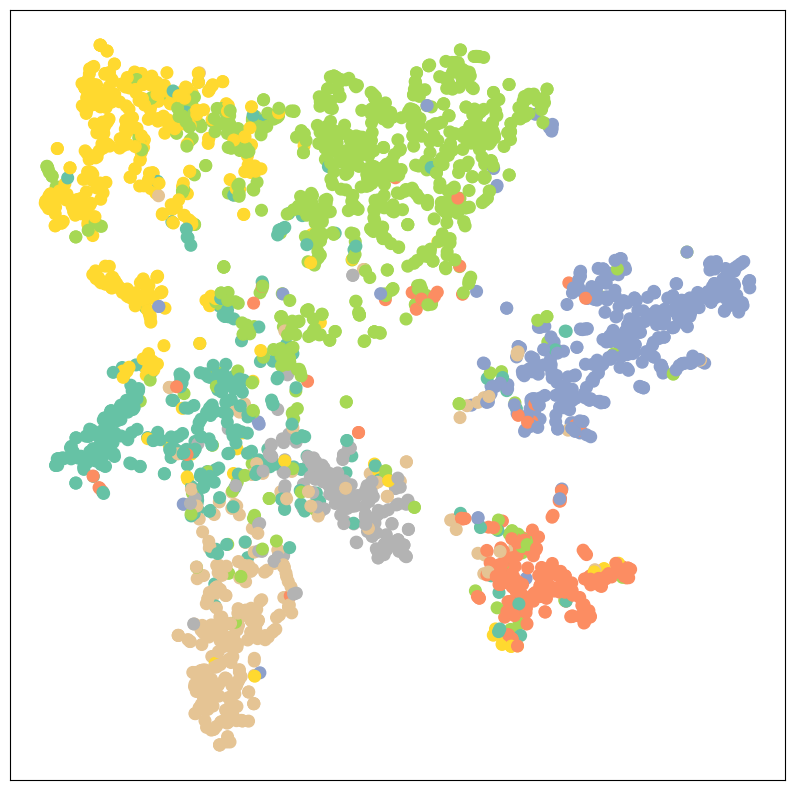

In [ ]:
# Visualize GAT embeddings
model.eval()  # Set to evaluation mode
out = model(data.x, data.edge_index)  # Get final output embeddings
visualize(out, color=data.y)  # Use the same TSNE plot function


###  Conclusion: Evaluating GAT on Node Classification

In this final section, we explored the use of a **Graph Attention Network (GAT)** as an alternative to GCNs. GAT introduces an attention mechanism that allows each node to dynamically weigh the importance of its neighbors during message passing, rather than treating all neighbors equally.

While GAT is a powerful and expressive model, our experiment resulted in a **slightly lower test accuracy (~80.6%)** compared to the **Graph Convolutional Network (GCN) (~81.5%)**.

This difference in performance may be due to:
- The **limited size and simplicity** of the Cora dataset.
- The absence of **full hyperparameter tuning** due to time constraints.
- The fact that GCN already performs strongly on homophilic graphs like Cora, where attention may not provide significant additional benefit.

Despite the lower score, this experiment was still valuable. It allowed us to:
- Understand how GAT differs from GCN conceptually and computationally.
- Compare the performance of both architectures under the same task.
- Visually inspect the learned embeddings through t-SNE projections.

> This experiment demonstrates that even advanced models like GAT may not always outperform simpler architectures on every dataset. But the exploration helped deepen our understanding of how different GNN architectures behave in practice.
